<h3>0.0 CARGA DE BIBLIOTECAS, VARIABLES, CLASES Y MÉTODOS IMPORTANTES</h3>

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout, LSTM, Dense, Embedding
import pickle
import json
import os

archivo_json = '../../Chessia_Data_Convert/Target Data/original/Datos-V2.json'
tokens_lilith03 = "tokens03.pkl"

class Partida:
    def __init__(self):
        self.movimientos = []
        self.resultado = None

# Función para cargar partidas en lotes
def cargar_partidas_por_rango(archivo_json, inicio=0, fin=103350):
    total_movimientos = []
    total_resultados = []
    with open(archivo_json, 'r') as file:
        # Carga el contenido completo como una lista de objetos JSON
        lista_json = json.load(file)
        
        # Itera sobre cada objeto JSON en la lista
        for i in range(inicio, fin):
            total_movimientos.append(lista_json[i]['partida']['movimientos'])
            total_resultados.append(lista_json[i]['partida']['resultado'])
            
    return total_movimientos, total_resultados

class PlotMetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        try:
            if self.model.history:
                plt.figure(figsize=(10, 5))
                plt.subplot(1, 2, 1)
                plt.plot(self.model.history.history['loss'], label='Training Loss')
                plt.plot(self.model.history.history['val_loss'], label='Validation Loss')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.title('Loss Over Time')
                plt.legend()

                plt.subplot(1, 2, 2)
                plt.plot(self.model.history.history['accuracy'], label='Training Accuracy')
                plt.plot(self.model.history.history['val_accuracy'], label='Validation Accuracy')
                plt.xlabel('Epoch')
                plt.ylabel('Accuracy')
                plt.title('Accuracy Over Time')
                plt.legend()

        except Exception as e:
            print("Error al mostrar la gráfica:", e)

<h3>3.0 PROCESADO DE DATOS DE LILITH03 - USA ProcesadorPGN_V2</h3>

In [14]:
# Convertir el generador en una lista y extraer la primera tupla
recogido = cargar_partidas_por_rango(archivo_json, fin=100000)
movimientos = recogido[0]
resultados = recogido[1]
# Crear y ajustar el tokenizador
tokenizer = Tokenizer()
tokenizer.fit_on_texts(movimientos)

#Borramos los antiguos tokens si los hubiese
if os.path.exists(tokens_lilith03):
    os.remove(tokens_lilith03)

# Guardar el objeto Tokenizer en un archivo usando pickle
with open(tokens_lilith03, "wb") as f:
    pickle.dump(tokenizer, f)

# Convertir todas las jugadas a secuencias de números enteros y luego a tensores válidos
movimientos_tokenized = tokenizer.texts_to_sequences(movimientos)
movimientos_tokenized = pad_sequences(movimientos_tokenized, maxlen=500, padding="pre")

resultados_tokenized = tf.one_hot([int(resultado) for resultado in resultados], depth=3)  # 3 clases: empate, victoria blanca, victoria negra

tensor_mov_entrena = tf.constant(movimientos_tokenized[:int(len(movimientos_tokenized) * 0.7) ])
tensor_res_entrena = tf.constant(resultados_tokenized [:int(len(resultados_tokenized)  * 0.7) ])
tensor_mov_prueba =  tf.constant(movimientos_tokenized[ int(len(movimientos_tokenized) * 0.7):])
tensor_res_prueba =  tf.constant(resultados_tokenized [ int(len(resultados_tokenized)  * 0.7):])

<h3>3.1 LILITH 03 - DEFINICIÓN, ENTRENAMIENTO Y GRÁFICAS DE DATOS CON POCOS VALORES</h3>

<h4>&ensp;&ensp;3.1.1 CREACIÓN DEL MODELO</h4>

In [15]:
# Definir el modelo
modelo = tf.keras.Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128),
    LSTM(units=256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    LSTM(units=128, dropout=0.2, recurrent_dropout=0.2),
    # Dense(units=256, activation='relu'),
    # Dropout(0.3),
    Dense(units=3, activation='softmax')
])

# Compilar el modelo
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) 
modelo.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

<h4>&ensp;&ensp;3.1.2 ENTRENAMIENTO</h4>

In [17]:
# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='modelo_checkpoint.keras', save_best_only=True)
# plot_metrics = PlotMetricsCallback()

try:
    modelo = tf.keras.models.load_model('modelo_checkpoint.keras')
    print("Checkpoint cargado. Continuando entrenamiento desde el último punto guardado...\n\n")
except:
    print("No se encontró un checkpoint existente. Iniciando un nuevo entrenamiento...\n\n")

# Entrenar el modelo con los callbacks
history = modelo.fit(
    tensor_mov_entrena,
    tensor_res_entrena,
    epochs=15,
    initial_epoch=3,  # Especificar la primera época a ejecutar
    batch_size=256,
    validation_data=(tensor_mov_prueba, tensor_res_prueba),
    # callbacks=[early_stopping, checkpoint, plot_metrics]
    callbacks=[early_stopping, checkpoint]
)

# Guardar el modelo final
modelo.save("lilith03.keras")

# Evaluar el modelo en los datos de prueba
loss, accuracy = modelo.evaluate(tensor_mov_prueba, tensor_res_prueba)
print("\n\nLoss en los datos de prueba:", loss)
print("Precisión en los datos de prueba:", accuracy)

Checkpoint cargado. Continuando entrenamiento desde el último punto guardado...


Epoch 4/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 1169s 4s/step - accuracy: 0.7101 - loss: 0.6791 - val_accuracy: 0.7442 - val_loss: 0.6022
Epoch 5/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 1033s 4s/step - accuracy: 0.7516 - loss: 0.5975 - val_accuracy: 0.7551 - val_loss: 0.5779
Epoch 6/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 1026s 4s/step - accuracy: 0.7744 - loss: 0.5439 - val_accuracy: 0.7715 - val_loss: 0.5490
Epoch 7/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 1035s 4s/step - accuracy: 0.7909 - loss: 0.5097 - val_accuracy: 0.7750 - val_loss: 0.5467
Epoch 8/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 1036s 4s/step - accuracy: 0.8004 - loss: 0.4966 - val_accuracy: 0.7794 - val_loss: 0.5354
Epoch 9/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 1041s 4s/step - accuracy: 0.7957 - loss: 0.5077 - val_accuracy: 0.7805 - val_loss: 0.5335
Epoch 10/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 1046s 4s/step - accuracy: 0.8133 - loss: 0.4722 - val_accuracy: 0.7759 - val_loss: 0.5512
Epoch 1

<h4>&ensp;&ensp;3.1.3 ESTADÍSTICAS Y GRÁFICAS</h4>

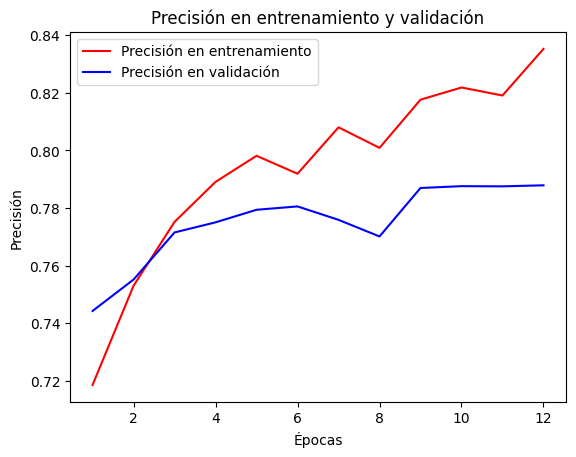

In [18]:
epocas = range(1, len(history.history['loss']) + 1)

# Graficar la precisión
plt.plot(epocas, history.history['accuracy'], 'r', label='Precisión en entrenamiento')
plt.plot(epocas, history.history['val_accuracy'], 'b', label='Precisión en validación')
plt.title('Precisión en entrenamiento y validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Graficar la pérdida
# plt.plot(epocas, history.history['loss'], 'r', label='Pérdida en entrenamiento')
# plt.plot(epocas, history.history['val_loss'], 'b', label='Pérdida en validación')
# plt.title('Pérdida en entrenamiento y validación')
# plt.xlabel('Épocas')
# plt.ylabel('Pérdida')
# plt.legend()
# plt.show()

<h3>3.2 PRUEBA DE PREDICCIÓN LILITH03</h3>

<h4>&ensp;&ensp;3.2.1 RECOGIDA DE DATOS Y TOKENS</h4>

In [4]:
# Convertir el generador en una lista y extraer la primera tupla
movimientos, resultados = cargar_partidas_por_rango(archivo_json, inicio=100000)

# Creación del tokenizer
nuevo_tokenizer = Tokenizer()

# Cargar el objeto Tokenizer desde el archivo
with open(tokens_lilith03, "rb") as f:
    nuevo_tokenizer = pickle.load(f)

tensor_mov_pred = tf.constant(pad_sequences(nuevo_tokenizer.texts_to_sequences(movimientos), maxlen=500, padding="pre"))

<h4>&ensp;&ensp;3.2.2 PREDICCIÓN Y MUESTRA DE DATOS</h4>

In [5]:
np.set_printoptions(suppress=True, precision=4)

lilith03 = tf.keras.models.load_model("lilith03.keras")

res_pred = lilith03.predict(tensor_mov_pred)
aciertos = sumaAciertos = 0

for i in range(len(res_pred)):
    if int(resultados[i]) != int(np.argmax(res_pred[i])): char = '❌'
    else: 
        char = '✅'
        aciertos += 1
        sumaAciertos += res_pred[i][np.argmax(res_pred[i])]

    print(f"Predicción: {str(res_pred[i]):>22} -- Dice: {np.argmax(res_pred[i])} -- Real: {resultados[i]}  {char}  --- Aciertos: {aciertos:>5}/{i+1:<5} - {int(aciertos/(i+1)*100):>3}%")


105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 208ms/step
Predicción: [0.5805 0.1052 0.3143] -- Dice: 0 -- Real: 0  ✅  --- Aciertos:     1/1     - 100%
Predicción: [0.7448 0.2481 0.0071] -- Dice: 0 -- Real: 1  ❌  --- Aciertos:     1/2     -  50%
Predicción: [0.328  0.5448 0.1272] -- Dice: 1 -- Real: 1  ✅  --- Aciertos:     2/3     -  66%
Predicción: [0.0277 0.9574 0.0149] -- Dice: 1 -- Real: 1  ✅  --- Aciertos:     3/4     -  75%
Predicción: [0.0373 0.9598 0.0029] -- Dice: 1 -- Real: 1  ✅  --- Aciertos:     4/5     -  80%
Predicción: [0.0299 0.9681 0.0021] -- Dice: 1 -- Real: 1  ✅  --- Aciertos:     5/6     -  83%
Predicción: [0.5075 0.425  0.0676] -- Dice: 0 -- Real: 1  ❌  --- Aciertos:     5/7     -  71%
Predicción: [0.0701 0.0317 0.8983] -- Dice: 2 -- Real: 2  ✅  --- Aciertos:     6/8     -  75%
Predicción: [0.1438 0.0606 0.7956] -- Dice: 2 -- Real: 0  ❌  --- Aciertos:     6/9     -  66%
Predicción: [0.1072 0.0365 0.8563] -- Dice: 2 -- Real: 0  ❌  --- Aciertos:     6/10    -  60%
Predicción: [0.2

In [5]:
print(f"{sumaAciertos/len(res_pred)}")

0.658820274570095
